In [1]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mamba_ssm import Mamba

In [36]:
!nvidia-smi

Wed Feb 21 16:05:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |   2015MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torch.nn.utils.rnn import pad_sequence

In [16]:
data_dir = "../data/data_preprocessed/crema_d/preprocessed/" 
data_x = np.load(f"{data_dir}crema_d.trill_embedding.train.npy", allow_pickle=True)
data_x.shape

(5144, 2048)

In [17]:
x_train = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_train = pad_sequence(x_train, batch_first=True)
x_train.shape

torch.Size([5144, 2048])

In [18]:
data_x = np.load(f"{data_dir}crema_d.trill_embedding.test.npy", allow_pickle=True)
x_test = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_test = pad_sequence(x_test, batch_first=True)
x_test.shape

torch.Size([1556, 2048])

In [19]:
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)
print(classnames)

['NEU' 'HAP' 'SAD' 'ANG' 'FEA' 'DIS']


In [20]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [21]:
labels = ['ANG', 'NEU', 'SAD']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

torch.Size([2508, 2048])
torch.Size([759, 2048])


In [22]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = x_train[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = x_test[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [24]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [25]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [26]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [27]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [28]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.019801980198019802/10 [00:00<04:27, 26.82s/it]

Train Epoch: 1 [0/2508 (0%)]	Loss: 1.103801
Mem before-during-after: 528384 98276352 20809216


  4%|███████▎                                                                                                                                                                       | 0.41584158415841604/10 [00:07<02:39, 16.63s/it]

Train Epoch: 1 [1280/2508 (51%)]	Loss: 1.050875
Mem before-during-after: 20809216 108751360 20809216


 10%|█████████████████▊                                                                                                                                                              | 1.0099009900990106/10 [00:16<02:24, 16.10s/it]


Test Epoch: 1	Accuracy: 221/736 (29%)

Train Epoch: 2 [0/2508 (0%)]	Loss: 1.108380
Mem before-during-after: 20805120 108751360 20809216


 14%|████████████████████████▉                                                                                                                                                       | 1.4158415841584169/10 [00:23<02:19, 16.27s/it]

Train Epoch: 2 [1280/2508 (51%)]	Loss: 1.093361
Mem before-during-after: 20809216 108751360 20809216


 20%|███████████████████████████████████▎                                                                                                                                            | 2.0099009900990112/10 [00:33<02:07, 15.92s/it]


Test Epoch: 2	Accuracy: 261/736 (34%)

Train Epoch: 3 [0/2508 (0%)]	Loss: 1.079923
Mem before-during-after: 20805120 108751360 20809216


 24%|██████████████████████████████████████████▌                                                                                                                                     | 2.4158415841584175/10 [00:39<02:04, 16.44s/it]

Train Epoch: 3 [1280/2508 (51%)]	Loss: 1.049655
Mem before-during-after: 20809216 108751360 20809216


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 3.009900990099012/10 [00:49<01:53, 16.23s/it]


Test Epoch: 3	Accuracy: 462/736 (61%)

Train Epoch: 4 [0/2508 (0%)]	Loss: 0.955922
Mem before-during-after: 20805120 108751360 20809216


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 3.4158415841584184/10 [00:56<01:50, 16.74s/it]

Train Epoch: 4 [1280/2508 (51%)]	Loss: 1.105965
Mem before-during-after: 20809216 108751360 20809216


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.009900990099013/10 [01:06<01:36, 16.13s/it]


Test Epoch: 4	Accuracy: 372/736 (49%)

Train Epoch: 5 [0/2508 (0%)]	Loss: 1.113236
Mem before-during-after: 20805120 108751360 20809216


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 4.415841584158419/10 [01:12<01:31, 16.44s/it]

Train Epoch: 5 [1280/2508 (51%)]	Loss: 0.656649
Mem before-during-after: 20809216 108751360 20809216


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 5.0099009900990135/10 [01:22<01:21, 16.38s/it]


Test Epoch: 5	Accuracy: 471/736 (62%)

Train Epoch: 6 [0/2508 (0%)]	Loss: 0.774232
Mem before-during-after: 20805120 108751360 20809216


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5.41584158415842/10 [01:29<01:15, 16.44s/it]

Train Epoch: 6 [1280/2508 (51%)]	Loss: 1.115410
Mem before-during-after: 20809216 108751360 20809216


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6.009900990099014/10 [01:38<01:04, 16.12s/it]


Test Epoch: 6	Accuracy: 318/736 (42%)

Train Epoch: 7 [0/2508 (0%)]	Loss: 1.083469
Mem before-during-after: 20805120 108751360 20809216


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6.415841584158421/10 [01:45<00:59, 16.48s/it]

Train Epoch: 7 [1280/2508 (51%)]	Loss: 0.712610
Mem before-during-after: 20809216 108751360 20809216


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7.009900990099015/10 [01:55<00:47, 15.94s/it]


Test Epoch: 7	Accuracy: 481/736 (63%)

Train Epoch: 8 [0/2508 (0%)]	Loss: 0.732566
Mem before-during-after: 20805120 108751360 20809216


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.4158415841584215/10 [02:01<00:41, 16.12s/it]

Train Epoch: 8 [1280/2508 (51%)]	Loss: 0.900686
Mem before-during-after: 20809216 108751360 20809216


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.009900990099014/10 [02:11<00:31, 15.95s/it]


Test Epoch: 8	Accuracy: 525/736 (69%)

Train Epoch: 9 [0/2508 (0%)]	Loss: 0.775951
Mem before-during-after: 20805120 108751360 20809216


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8.415841584158384/10 [02:18<00:26, 16.50s/it]

Train Epoch: 9 [1280/2508 (51%)]	Loss: 1.098814
Mem before-during-after: 20809216 108751360 20809216


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.009900990098926/10 [02:27<00:15, 16.10s/it]


Test Epoch: 9	Accuracy: 449/736 (59%)

Train Epoch: 10 [0/2508 (0%)]	Loss: 0.851085
Mem before-during-after: 20805120 108751360 20809216


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.415841584158295/10 [02:34<00:09, 16.66s/it]

Train Epoch: 10 [1280/2508 (51%)]	Loss: 0.715603
Mem before-during-after: 20809216 108751360 20809216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999828/10 [02:44<00:00, 16.42s/it]


Test Epoch: 10	Accuracy: 511/736 (67%)



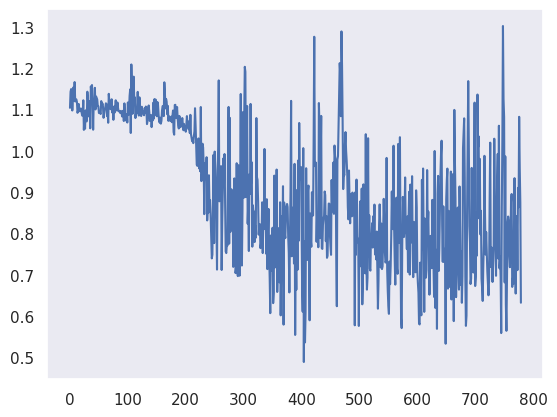

In [29]:
plt.plot(train_losses)

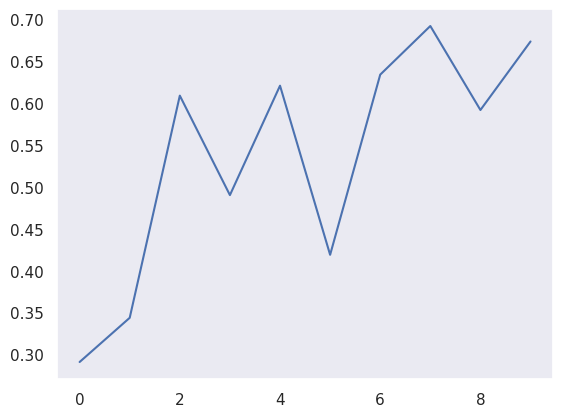

In [30]:
plt.plot(test_accuracy)

In [31]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [32]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 514/736 (0.6984)
{'acc_detail': tensor([0.9308, 0.4864, 0.6445], device='cuda:0'),
 'acc_unweighted': tensor(0.6872, device='cuda:0'),
 'acc_weighted': tensor(0.6984, device='cuda:0'),
 'f1s': tensor(0.6811, device='cuda:0'),
 'f1s_detail': tensor([0.7961, 0.5284, 0.7190], device='cuda:0'),
 'precision_detail': tensor([0.6954, 0.5784, 0.8128], device='cuda:0'),
 'recall_detail': tensor([0.9308, 0.4864, 0.6445], device='cuda:0'),
 'rocauc': tensor([0.9457, 0.7429, 0.8904], device='cuda:0'),
 'uar': tensor(0.6872, device='cuda:0'),
 'wap': tensor(0.7013, device='cuda:0')}


tensor([[242,  18,   0],
        [ 75, 107,  38],
        [ 31,  60, 165]], device='cuda:0')

In [34]:
model_path = '../models_cremad3/cremad_label3_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [35]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:08, 19.39s/it]

Train Epoch: 11 [0/2508 (0%)]	Loss: 0.832731
Mem before-during-after: 19798528 107744768 20855296


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:07<15:29, 18.76s/it]

Train Epoch: 11 [1280/2508 (51%)]	Loss: 0.583193
Mem before-during-after: 20855296 108797440 20855296


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:18<15:00, 18.38s/it]


Test Epoch: 11	Accuracy: 517/736 (68%)

saved model: ../models_cremad3/cremad_label3_m12new_best_11epoch.pt
Train Epoch: 12 [0/2508 (0%)]	Loss: 0.783334
Mem before-during-after: 20851200 108797440 20855296


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:26<15:12, 18.79s/it]

Train Epoch: 12 [1280/2508 (51%)]	Loss: 0.795652
Mem before-during-after: 20855296 108797440 20855296


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:37<14:46, 18.48s/it]


Test Epoch: 12	Accuracy: 522/736 (69%)

saved model: ../models_cremad3/cremad_label3_m12new_best_12epoch.pt
Train Epoch: 13 [0/2508 (0%)]	Loss: 0.668745
Mem before-during-after: 20851200 108797440 20855296


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:45<15:02, 18.97s/it]

Train Epoch: 13 [1280/2508 (51%)]	Loss: 0.583069
Mem before-during-after: 20855296 108797440 20855296


  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [00:56<14:25, 18.41s/it]


Test Epoch: 13	Accuracy: 522/736 (69%)

Train Epoch: 14 [0/2508 (0%)]	Loss: 0.762520
Mem before-during-after: 20851200 108797440 20855296


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:03<14:39, 18.87s/it]

Train Epoch: 14 [1280/2508 (51%)]	Loss: 0.876204
Mem before-during-after: 20855296 108797440 20855296


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:14<14:05, 18.39s/it]


Test Epoch: 14	Accuracy: 507/736 (67%)

Train Epoch: 15 [0/2508 (0%)]	Loss: 0.636749
Mem before-during-after: 20851200 108797440 20855296


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:22<14:19, 18.85s/it]

Train Epoch: 15 [1280/2508 (51%)]	Loss: 0.799123
Mem before-during-after: 20855296 108797440 20855296


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:33<13:42, 18.29s/it]


Test Epoch: 15	Accuracy: 491/736 (65%)

Train Epoch: 16 [0/2508 (0%)]	Loss: 0.773857
Mem before-during-after: 20851200 108797440 20855296


 11%|███████████████████▎                                                                                                                                                              | 5.41584158415842/50 [01:40<13:37, 18.34s/it]

Train Epoch: 16 [1280/2508 (51%)]	Loss: 1.129833
Mem before-during-after: 20855296 108797440 20855296


 12%|█████████████████████▎                                                                                                                                                           | 6.009900990099014/50 [01:51<13:14, 18.06s/it]


Test Epoch: 16	Accuracy: 460/736 (61%)

Train Epoch: 17 [0/2508 (0%)]	Loss: 0.610411
Mem before-during-after: 20851200 108797440 20855296


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [01:59<13:26, 18.51s/it]

Train Epoch: 17 [1280/2508 (51%)]	Loss: 0.833390
Mem before-during-after: 20855296 108797440 20855296


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:10<13:10, 18.40s/it]


Test Epoch: 17	Accuracy: 510/736 (67%)

Train Epoch: 18 [0/2508 (0%)]	Loss: 0.642170
Mem before-during-after: 20851200 108797440 20855296


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:17<13:29, 19.02s/it]

Train Epoch: 18 [1280/2508 (51%)]	Loss: 0.761274
Mem before-during-after: 20855296 108797440 20855296


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [02:28<12:43, 18.17s/it]


Test Epoch: 18	Accuracy: 491/736 (65%)

Train Epoch: 19 [0/2508 (0%)]	Loss: 1.003650
Mem before-during-after: 20851200 108797440 20855296


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:36<12:59, 18.75s/it]

Train Epoch: 19 [1280/2508 (51%)]	Loss: 0.916530
Mem before-during-after: 20855296 108797440 20855296


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:47<12:31, 18.32s/it]


Test Epoch: 19	Accuracy: 514/736 (68%)

Train Epoch: 20 [0/2508 (0%)]	Loss: 0.654644
Mem before-during-after: 20851200 108797440 20855296


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [02:55<12:21, 18.28s/it]

Train Epoch: 20 [1280/2508 (51%)]	Loss: 0.796694
Mem before-during-after: 20855296 108797440 20855296


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:06<11:56, 17.92s/it]


Test Epoch: 20	Accuracy: 402/736 (53%)

Train Epoch: 21 [0/2508 (0%)]	Loss: 0.879086
Mem before-during-after: 20851200 108797440 20855296


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:13<12:30, 18.97s/it]

Train Epoch: 21 [1280/2508 (51%)]	Loss: 0.782279
Mem before-during-after: 20855296 108797440 20855296


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:24<12:11, 18.76s/it]


Test Epoch: 21	Accuracy: 487/736 (64%)

Train Epoch: 22 [0/2508 (0%)]	Loss: 0.708266
Mem before-during-after: 20851200 108797440 20855296


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.415841584158118/50 [03:32<12:14, 19.04s/it]

Train Epoch: 22 [1280/2508 (51%)]	Loss: 0.747288
Mem before-during-after: 20855296 108797440 20855296


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:43<11:27, 18.09s/it]


Test Epoch: 22	Accuracy: 518/736 (68%)

Train Epoch: 23 [0/2508 (0%)]	Loss: 0.691820
Mem before-during-after: 20851200 108797440 20855296


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [03:51<11:45, 18.78s/it]

Train Epoch: 23 [1280/2508 (51%)]	Loss: 0.773212
Mem before-during-after: 20855296 108797440 20855296


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.00990099009857/50 [04:02<11:06, 18.02s/it]


Test Epoch: 23	Accuracy: 387/736 (51%)

Train Epoch: 24 [0/2508 (0%)]	Loss: 0.894540
Mem before-during-after: 20851200 108797440 20855296


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:09<11:31, 18.91s/it]

Train Epoch: 24 [1280/2508 (51%)]	Loss: 0.794119
Mem before-during-after: 20855296 108797440 20855296


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:20<11:17, 18.82s/it]


Test Epoch: 24	Accuracy: 508/736 (67%)

Train Epoch: 25 [0/2508 (0%)]	Loss: 0.746269
Mem before-during-after: 20851200 108797440 20855296


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:28<11:21, 19.14s/it]

Train Epoch: 25 [1280/2508 (51%)]	Loss: 0.586990
Mem before-during-after: 20855296 108797440 20855296


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:39<10:57, 18.79s/it]


Test Epoch: 25	Accuracy: 484/736 (64%)

Train Epoch: 26 [0/2508 (0%)]	Loss: 0.661686
Mem before-during-after: 20851200 108797440 20855296


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [04:47<10:51, 18.84s/it]

Train Epoch: 26 [1280/2508 (51%)]	Loss: 0.561061
Mem before-during-after: 20855296 108797440 20855296


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [04:58<10:22, 18.32s/it]


Test Epoch: 26	Accuracy: 486/736 (64%)

Train Epoch: 27 [0/2508 (0%)]	Loss: 0.680844
Mem before-during-after: 20851200 108797440 20855296


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:06<10:43, 19.15s/it]

Train Epoch: 27 [1280/2508 (51%)]	Loss: 0.581544
Mem before-during-after: 20855296 108797440 20855296


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:17<10:18, 18.75s/it]


Test Epoch: 27	Accuracy: 490/736 (65%)

Train Epoch: 28 [0/2508 (0%)]	Loss: 0.773919
Mem before-during-after: 20851200 108797440 20855296


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:25<10:03, 18.52s/it]

Train Epoch: 28 [1280/2508 (51%)]	Loss: 0.684477
Mem before-during-after: 20855296 108797440 20855296


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:36<09:41, 18.17s/it]


Test Epoch: 28	Accuracy: 445/736 (59%)

Train Epoch: 29 [0/2508 (0%)]	Loss: 0.733355
Mem before-during-after: 20851200 108797440 20855296


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [05:43<09:56, 18.89s/it]

Train Epoch: 29 [1280/2508 (51%)]	Loss: 0.852159
Mem before-during-after: 20855296 108797440 20855296


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [05:55<09:50, 19.07s/it]


Test Epoch: 29	Accuracy: 422/736 (56%)

Train Epoch: 30 [0/2508 (0%)]	Loss: 1.351773
Mem before-during-after: 20851200 108797440 20855296


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:02<09:32, 18.72s/it]

Train Epoch: 30 [1280/2508 (51%)]	Loss: 0.588068
Mem before-during-after: 20855296 108797440 20855296


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00990099009795/50 [06:13<08:56, 17.90s/it]


Test Epoch: 30	Accuracy: 485/736 (64%)

Train Epoch: 31 [0/2508 (0%)]	Loss: 0.887058
Mem before-during-after: 20851200 108797440 20855296


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:21<08:59, 18.25s/it]

Train Epoch: 31 [1280/2508 (51%)]	Loss: 1.177021
Mem before-during-after: 20855296 108797440 20855296


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:31<08:40, 17.96s/it]


Test Epoch: 31	Accuracy: 514/736 (68%)

Train Epoch: 32 [0/2508 (0%)]	Loss: 0.771378
Mem before-during-after: 20851200 108797440 20855296


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [06:39<08:44, 18.33s/it]

Train Epoch: 32 [1280/2508 (51%)]	Loss: 1.228065
Mem before-during-after: 20855296 108797440 20855296


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [06:50<08:22, 17.95s/it]


Test Epoch: 32	Accuracy: 494/736 (65%)

Train Epoch: 33 [0/2508 (0%)]	Loss: 0.735050
Mem before-during-after: 20851200 108797440 20855296


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [06:57<08:26, 18.37s/it]

Train Epoch: 33 [1280/2508 (51%)]	Loss: 0.983063
Mem before-during-after: 20855296 108797440 20855296


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:08<08:18, 18.45s/it]


Test Epoch: 33	Accuracy: 453/736 (60%)

Train Epoch: 34 [0/2508 (0%)]	Loss: 1.181239
Mem before-during-after: 20851200 108797440 20855296


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:16<08:24, 18.96s/it]

Train Epoch: 34 [1280/2508 (51%)]	Loss: 0.553761
Mem before-during-after: 20855296 108797440 20855296


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:27<08:05, 18.70s/it]


Test Epoch: 34	Accuracy: 490/736 (65%)

Train Epoch: 35 [0/2508 (0%)]	Loss: 0.732094
Mem before-during-after: 20851200 108797440 20855296


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [07:35<08:04, 18.92s/it]

Train Epoch: 35 [1280/2508 (51%)]	Loss: 1.086162
Mem before-during-after: 20855296 108797440 20855296


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [07:46<07:33, 18.14s/it]


Test Epoch: 35	Accuracy: 532/736 (70%)

saved model: ../models_cremad3/cremad_label3_m12new_best_35epoch.pt
Train Epoch: 36 [0/2508 (0%)]	Loss: 0.656243
Mem before-during-after: 20851200 108797440 20855296


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [07:53<07:32, 18.40s/it]

Train Epoch: 36 [1280/2508 (51%)]	Loss: 0.938398
Mem before-during-after: 20855296 108797440 20855296


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.009900990097417/50 [08:04<07:13, 18.06s/it]


Test Epoch: 36	Accuracy: 484/736 (64%)

Train Epoch: 37 [0/2508 (0%)]	Loss: 0.605116
Mem before-during-after: 20851200 108797440 20855296


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:12<07:23, 18.81s/it]

Train Epoch: 37 [1280/2508 (51%)]	Loss: 0.580581
Mem before-during-after: 20855296 108797440 20855296


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:23<06:57, 18.17s/it]


Test Epoch: 37	Accuracy: 499/736 (66%)

Train Epoch: 38 [0/2508 (0%)]	Loss: 0.891295
Mem before-during-after: 20851200 108797440 20855296


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [08:30<07:15, 19.30s/it]

Train Epoch: 38 [1280/2508 (51%)]	Loss: 0.841971
Mem before-during-after: 20855296 108797440 20855296


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [08:41<06:42, 18.29s/it]


Test Epoch: 38	Accuracy: 525/736 (69%)

Train Epoch: 39 [0/2508 (0%)]	Loss: 0.649933
Mem before-during-after: 20851200 108797440 20855296


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [08:49<06:33, 18.21s/it]

Train Epoch: 39 [1280/2508 (51%)]	Loss: 0.537323
Mem before-during-after: 20855296 108797440 20855296


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.00990099009715/50 [08:59<06:13, 17.81s/it]


Test Epoch: 39	Accuracy: 523/736 (69%)

Train Epoch: 40 [0/2508 (0%)]	Loss: 0.738714
Mem before-during-after: 20851200 108797440 20855296


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:07<06:15, 18.24s/it]

Train Epoch: 40 [1280/2508 (51%)]	Loss: 0.563042
Mem before-during-after: 20855296 108797440 20855296


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:17<05:56, 17.85s/it]


Test Epoch: 40	Accuracy: 417/736 (55%)

Train Epoch: 41 [0/2508 (0%)]	Loss: 1.128240
Mem before-during-after: 20851200 108797440 20855296


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:25<06:01, 18.48s/it]

Train Epoch: 41 [1280/2508 (51%)]	Loss: 0.678123
Mem before-during-after: 20855296 108797440 20855296


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.009900990096973/50 [09:36<05:52, 18.55s/it]


Test Epoch: 41	Accuracy: 506/736 (67%)

Train Epoch: 42 [0/2508 (0%)]	Loss: 0.661813
Mem before-during-after: 20851200 108797440 20855296


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [09:43<05:53, 19.01s/it]

Train Epoch: 42 [1280/2508 (51%)]	Loss: 0.855830
Mem before-during-after: 20855296 108797440 20855296


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [09:55<05:27, 18.20s/it]


Test Epoch: 42	Accuracy: 520/736 (69%)

Train Epoch: 43 [0/2508 (0%)]	Loss: 0.635841
Mem before-during-after: 20851200 108797440 20855296


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:02<05:31, 18.84s/it]

Train Epoch: 43 [1280/2508 (51%)]	Loss: 1.080383
Mem before-during-after: 20855296 108797440 20855296


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00990099009716/50 [10:13<05:04, 17.95s/it]


Test Epoch: 43	Accuracy: 522/736 (69%)

Train Epoch: 44 [0/2508 (0%)]	Loss: 0.695346
Mem before-during-after: 20851200 108797440 20855296


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:21<05:09, 18.65s/it]

Train Epoch: 44 [1280/2508 (51%)]	Loss: 0.549478
Mem before-during-after: 20855296 108797440 20855296


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [10:31<04:52, 18.27s/it]


Test Epoch: 44	Accuracy: 464/736 (61%)

Train Epoch: 45 [0/2508 (0%)]	Loss: 0.706734
Mem before-during-after: 20851200 108797440 20855296


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [10:39<04:51, 18.69s/it]

Train Epoch: 45 [1280/2508 (51%)]	Loss: 0.989222
Mem before-during-after: 20855296 108797440 20855296


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [10:50<04:32, 18.16s/it]


Test Epoch: 45	Accuracy: 500/736 (66%)

Train Epoch: 46 [0/2508 (0%)]	Loss: 0.791415
Mem before-during-after: 20851200 108797440 20855296


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [10:58<04:28, 18.40s/it]

Train Epoch: 46 [1280/2508 (51%)]	Loss: 1.023922
Mem before-during-after: 20855296 108797440 20855296


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00990099009797/50 [11:08<04:18, 18.48s/it]


Test Epoch: 46	Accuracy: 383/736 (50%)

Train Epoch: 47 [0/2508 (0%)]	Loss: 0.908448
Mem before-during-after: 20851200 108797440 20855296


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:16<04:10, 18.47s/it]

Train Epoch: 47 [1280/2508 (51%)]	Loss: 0.711141
Mem before-during-after: 20855296 108797440 20855296


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.00990099009824/50 [11:27<03:58, 18.35s/it]


Test Epoch: 47	Accuracy: 530/736 (70%)

Train Epoch: 48 [0/2508 (0%)]	Loss: 0.490690
Mem before-during-after: 20851200 108797440 20855296


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [11:35<03:57, 18.90s/it]

Train Epoch: 48 [1280/2508 (51%)]	Loss: 0.654215
Mem before-during-after: 20855296 108797440 20855296


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [11:46<03:44, 18.71s/it]


Test Epoch: 48	Accuracy: 532/736 (70%)

Train Epoch: 49 [0/2508 (0%)]	Loss: 0.693253
Mem before-during-after: 20851200 108797440 20855296


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [11:54<03:39, 18.95s/it]

Train Epoch: 49 [1280/2508 (51%)]	Loss: 0.817557
Mem before-during-after: 20855296 108797440 20855296


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [12:05<03:17, 17.94s/it]


Test Epoch: 49	Accuracy: 519/736 (68%)

Train Epoch: 50 [0/2508 (0%)]	Loss: 0.870135
Mem before-during-after: 20851200 108797440 20855296


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:12<03:13, 18.32s/it]

Train Epoch: 50 [1280/2508 (51%)]	Loss: 0.542196
Mem before-during-after: 20855296 108797440 20855296


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [12:23<03:02, 18.22s/it]


Test Epoch: 50	Accuracy: 487/736 (64%)

Train Epoch: 51 [0/2508 (0%)]	Loss: 0.713064
Mem before-during-after: 20851200 108797440 20855296


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [12:31<02:57, 18.52s/it]

Train Epoch: 51 [1280/2508 (51%)]	Loss: 0.981983
Mem before-during-after: 20855296 108797440 20855296


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [12:42<02:42, 18.08s/it]


Test Epoch: 51	Accuracy: 520/736 (69%)

Train Epoch: 52 [0/2508 (0%)]	Loss: 0.620505
Mem before-during-after: 20851200 108797440 20855296


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [12:49<02:40, 18.67s/it]

Train Epoch: 52 [1280/2508 (51%)]	Loss: 0.656505
Mem before-during-after: 20855296 108797440 20855296


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00990099009959/50 [13:00<02:26, 18.32s/it]


Test Epoch: 52	Accuracy: 538/736 (71%)

saved model: ../models_cremad3/cremad_label3_m12new_best_52epoch.pt
Train Epoch: 53 [0/2508 (0%)]	Loss: 0.411114
Mem before-during-after: 20851200 108797440 20855296


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:08<02:35, 20.45s/it]

Train Epoch: 53 [1280/2508 (51%)]	Loss: 0.566776
Mem before-during-after: 20855296 108797440 20855296


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [13:19<02:09, 18.52s/it]


Test Epoch: 53	Accuracy: 506/736 (67%)

Train Epoch: 54 [0/2508 (0%)]	Loss: 0.903012
Mem before-during-after: 20851200 108797440 20855296


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [13:27<02:05, 19.06s/it]

Train Epoch: 54 [1280/2508 (51%)]	Loss: 0.726770
Mem before-during-after: 20855296 108797440 20855296


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [13:38<01:49, 18.29s/it]


Test Epoch: 54	Accuracy: 512/736 (67%)

Train Epoch: 55 [0/2508 (0%)]	Loss: 0.594101
Mem before-during-after: 20851200 108797440 20855296


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.415841584159644/50 [13:46<01:46, 19.04s/it]

Train Epoch: 55 [1280/2508 (51%)]	Loss: 0.916305
Mem before-during-after: 20855296 108797440 20855296


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 45.0099009901004/50 [13:57<01:29, 18.03s/it]


Test Epoch: 55	Accuracy: 532/736 (70%)

Train Epoch: 56 [0/2508 (0%)]	Loss: 0.908237
Mem before-during-after: 20851200 108797440 20855296


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:04<01:24, 18.33s/it]

Train Epoch: 56 [1280/2508 (51%)]	Loss: 0.830296
Mem before-during-after: 20855296 108797440 20855296


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [14:15<01:11, 17.99s/it]


Test Epoch: 56	Accuracy: 527/736 (69%)

Train Epoch: 57 [0/2508 (0%)]	Loss: 0.748840
Mem before-during-after: 20851200 108797440 20855296


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [14:23<01:05, 18.35s/it]

Train Epoch: 57 [1280/2508 (51%)]	Loss: 0.666896
Mem before-during-after: 20855296 108797440 20855296


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [14:34<00:54, 18.30s/it]


Test Epoch: 57	Accuracy: 532/736 (70%)

Train Epoch: 58 [0/2508 (0%)]	Loss: 0.835039
Mem before-during-after: 20851200 108797440 20855296


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [14:41<00:48, 18.60s/it]

Train Epoch: 58 [1280/2508 (51%)]	Loss: 0.700074
Mem before-during-after: 20855296 108797440 20855296


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [14:52<00:35, 18.00s/it]


Test Epoch: 58	Accuracy: 533/736 (70%)

Train Epoch: 59 [0/2508 (0%)]	Loss: 0.589135
Mem before-during-after: 20851200 108797440 20855296


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [14:59<00:29, 18.47s/it]

Train Epoch: 59 [1280/2508 (51%)]	Loss: 0.470031
Mem before-during-after: 20855296 108797440 20855296


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [15:11<00:18, 18.58s/it]


Test Epoch: 59	Accuracy: 515/736 (68%)

Train Epoch: 60 [0/2508 (0%)]	Loss: 0.713073
Mem before-during-after: 20851200 108797440 20855296


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.40594059406198/50 [15:18<00:11, 19.22s/it]

Train Epoch: 60 [1280/2508 (51%)]	Loss: 0.702387
Mem before-during-after: 20855296 108797440 20855296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99009900990372/50 [15:29<00:00, 19.77s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [15:29<00:00, 18.60s/it]


Test Epoch: 60	Accuracy: 460/736 (61%)



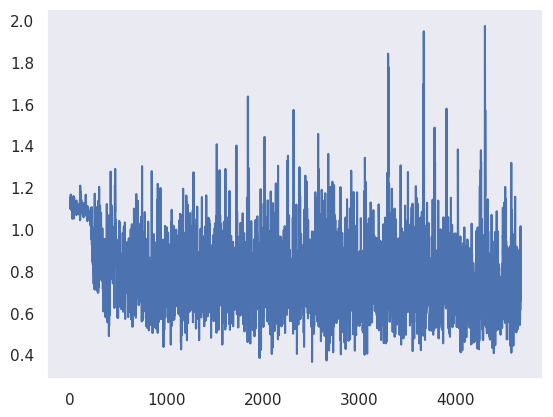

In [36]:
plt.plot(train_losses)

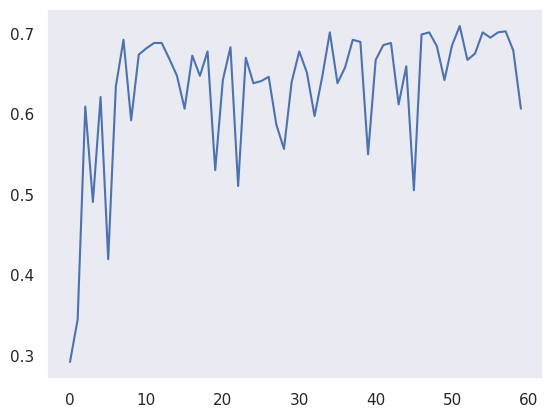

In [37]:
plt.plot(test_accuracy)

In [38]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 461/736 (0.6264)
{'acc_detail': tensor([0.6500, 0.2318, 0.9414], device='cuda:0'),
 'acc_unweighted': tensor(0.6077, device='cuda:0'),
 'acc_weighted': tensor(0.6264, device='cuda:0'),
 'f1s': tensor(0.5897, device='cuda:0'),
 'f1s_detail': tensor([0.7735, 0.2890, 0.7067], device='cuda:0'),
 'precision_detail': tensor([0.9548, 0.3835, 0.5657], device='cuda:0'),
 'recall_detail': tensor([0.6500, 0.2318, 0.9414], device='cuda:0'),
 'rocauc': tensor([0.9618, 0.7266, 0.9080], device='cuda:0'),
 'uar': tensor(0.6077, device='cuda:0'),
 'wap': tensor(0.6487, device='cuda:0')}


tensor([[169,  69,  22],
        [  6,  51, 163],
        [  2,  13, 241]], device='cuda:0')

In [39]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [40]:
best_epoch = 52
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 538/736 (0.7310)
{'acc_detail': tensor([0.8417, 0.5324, 0.7854], device='cuda:0'),
 'acc_unweighted': tensor(0.7198, device='cuda:0'),
 'acc_weighted': tensor(0.7310, device='cuda:0'),
 'f1s': tensor(0.7187, device='cuda:0'),
 'f1s_detail': tensor([0.8385, 0.5542, 0.7635], device='cuda:0'),
 'precision_detail': tensor([0.8352, 0.5779, 0.7428], device='cuda:0'),
 'recall_detail': tensor([0.8417, 0.5324, 0.7854], device='cuda:0'),
 'rocauc': tensor([0.9578, 0.8043, 0.9028], device='cuda:0'),
 'uar': tensor(0.7198, device='cuda:0'),
 'wap': tensor(0.7269, device='cuda:0')}


tensor([[218,  39,   2],
        [ 32, 115,  69],
        [ 11,  45, 205]], device='cuda:0')

In [41]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [42]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/40 [00:00<12:54, 19.36s/it]

Train Epoch: 61 [0/2508 (0%)]	Loss: 0.716139
Mem before-during-after: 22078464 110024704 23134720


  1%|█▊                                                                                                                                                                             | 0.41584158415841604/40 [00:07<12:32, 19.00s/it]

Train Epoch: 61 [1280/2508 (51%)]	Loss: 0.762267
Mem before-during-after: 23134720 111076864 23134720


  3%|████▍                                                                                                                                                                           | 1.0099009900990106/40 [00:18<12:01, 18.51s/it]


Test Epoch: 61	Accuracy: 540/736 (71%)

saved model: ../models_cremad3/cremad_label3_m12new_best_61epoch.pt
Train Epoch: 62 [0/2508 (0%)]	Loss: 0.649303
Mem before-during-after: 23130624 111076864 23134720


  4%|██████▏                                                                                                                                                                         | 1.4158415841584169/40 [00:26<12:04, 18.79s/it]

Train Epoch: 62 [1280/2508 (51%)]	Loss: 0.587402
Mem before-during-after: 23134720 111076864 23134720


  5%|████████▊                                                                                                                                                                       | 2.0099009900990112/40 [00:37<11:52, 18.76s/it]


Test Epoch: 62	Accuracy: 531/736 (70%)

Train Epoch: 63 [0/2508 (0%)]	Loss: 0.517664
Mem before-during-after: 23130624 111076864 23134720


  6%|██████████▋                                                                                                                                                                     | 2.4158415841584175/40 [00:45<11:45, 18.76s/it]

Train Epoch: 63 [1280/2508 (51%)]	Loss: 0.478880
Mem before-during-after: 23134720 111076864 23134720


  8%|█████████████▎                                                                                                                                                                   | 3.009900990099012/40 [00:56<11:28, 18.61s/it]


Test Epoch: 63	Accuracy: 547/736 (72%)

saved model: ../models_cremad3/cremad_label3_m12new_best_63epoch.pt
Train Epoch: 64 [0/2508 (0%)]	Loss: 1.138748
Mem before-during-after: 23130624 111076864 23134720


  9%|███████████████                                                                                                                                                                 | 3.4158415841584184/40 [01:04<11:31, 18.90s/it]

Train Epoch: 64 [1280/2508 (51%)]	Loss: 0.690801
Mem before-during-after: 23134720 111076864 23134720


 10%|█████████████████▋                                                                                                                                                               | 4.009900990099013/40 [01:15<11:23, 18.98s/it]


Test Epoch: 64	Accuracy: 543/736 (72%)

Train Epoch: 65 [0/2508 (0%)]	Loss: 0.543197
Mem before-during-after: 23130624 111076864 23134720


 11%|███████████████████▌                                                                                                                                                             | 4.415841584158419/40 [01:23<11:22, 19.18s/it]

Train Epoch: 65 [1280/2508 (51%)]	Loss: 0.567969
Mem before-during-after: 23134720 111076864 23134720


 13%|██████████████████████                                                                                                                                                          | 5.0099009900990135/40 [01:34<10:56, 18.76s/it]


Test Epoch: 65	Accuracy: 541/736 (71%)

Train Epoch: 66 [0/2508 (0%)]	Loss: 0.481901
Mem before-during-after: 23130624 111076864 23134720


 14%|████████████████████████                                                                                                                                                          | 5.41584158415842/40 [01:42<10:56, 18.98s/it]

Train Epoch: 66 [1280/2508 (51%)]	Loss: 0.486773
Mem before-during-after: 23134720 111076864 23134720


 15%|██████████████████████████▌                                                                                                                                                      | 6.009900990099014/40 [01:53<10:22, 18.31s/it]


Test Epoch: 66	Accuracy: 525/736 (69%)

Train Epoch: 67 [0/2508 (0%)]	Loss: 0.686670
Mem before-during-after: 23130624 111076864 23134720


 16%|████████████████████████████▍                                                                                                                                                    | 6.415841584158421/40 [02:00<10:25, 18.64s/it]

Train Epoch: 67 [1280/2508 (51%)]	Loss: 0.658368
Mem before-during-after: 23134720 111076864 23134720


 18%|███████████████████████████████                                                                                                                                                  | 7.009900990099015/40 [02:12<10:16, 18.70s/it]


Test Epoch: 67	Accuracy: 537/736 (71%)

Train Epoch: 68 [0/2508 (0%)]	Loss: 0.638185
Mem before-during-after: 23130624 111076864 23134720


 19%|████████████████████████████████▋                                                                                                                                               | 7.4158415841584215/40 [02:19<10:18, 18.97s/it]

Train Epoch: 68 [1280/2508 (51%)]	Loss: 0.665604
Mem before-during-after: 23134720 111076864 23134720


 20%|███████████████████████████████████▍                                                                                                                                             | 8.009900990099014/40 [02:30<09:44, 18.26s/it]


Test Epoch: 68	Accuracy: 541/736 (71%)

Train Epoch: 69 [0/2508 (0%)]	Loss: 0.638031
Mem before-during-after: 23130624 111076864 23134720


 21%|█████████████████████████████████████▏                                                                                                                                           | 8.415841584158384/40 [02:38<09:46, 18.58s/it]

Train Epoch: 69 [1280/2508 (51%)]	Loss: 0.628147
Mem before-during-after: 23134720 111076864 23134720


 23%|███████████████████████████████████████▊                                                                                                                                         | 9.009900990098926/40 [02:49<09:29, 18.39s/it]


Test Epoch: 69	Accuracy: 532/736 (70%)

Train Epoch: 70 [0/2508 (0%)]	Loss: 0.680129
Mem before-during-after: 23130624 111076864 23134720


 24%|█████████████████████████████████████████▋                                                                                                                                       | 9.415841584158295/40 [02:57<10:22, 20.36s/it]

Train Epoch: 70 [1280/2508 (51%)]	Loss: 0.834217
Mem before-during-after: 23134720 111076864 23134720


 25%|████████████████████████████████████████████                                                                                                                                    | 10.009900990098837/40 [03:08<09:11, 18.40s/it]


Test Epoch: 70	Accuracy: 549/736 (72%)

saved model: ../models_cremad3/cremad_label3_m12new_best_70epoch.pt
Train Epoch: 71 [0/2508 (0%)]	Loss: 0.624322
Mem before-during-after: 23130624 111076864 23134720


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 10.415841584158207/40 [03:16<09:30, 19.27s/it]

Train Epoch: 71 [1280/2508 (51%)]	Loss: 0.719387
Mem before-during-after: 23134720 111076864 23134720


 27%|████████████████████████████████████████████████▍                                                                                                                               | 10.999999999999739/40 [03:27<08:48, 18.21s/it]


Test Epoch: 71	Accuracy: 543/736 (72%)



 28%|████████████████████████████████████████████████▍                                                                                                                               | 11.019801980197757/40 [03:28<09:12, 19.06s/it]

Train Epoch: 72 [0/2508 (0%)]	Loss: 0.865911
Mem before-during-after: 23130624 111076864 23134720


 29%|██████████████████████████████████████████████████▏                                                                                                                             | 11.415841584158118/40 [03:35<09:18, 19.55s/it]

Train Epoch: 72 [1280/2508 (51%)]	Loss: 0.705216
Mem before-during-after: 23134720 111076864 23134720


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 12.009900990098659/40 [03:47<08:49, 18.92s/it]


Test Epoch: 72	Accuracy: 554/736 (73%)

saved model: ../models_cremad3/cremad_label3_m12new_best_72epoch.pt
Train Epoch: 73 [0/2508 (0%)]	Loss: 0.469865
Mem before-during-after: 23130624 111076864 23134720


 31%|██████████████████████████████████████████████████████▋                                                                                                                         | 12.415841584158029/40 [03:55<08:43, 19.00s/it]

Train Epoch: 73 [1280/2508 (51%)]	Loss: 0.711585
Mem before-during-after: 23134720 111076864 23134720


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13.00990099009857/40 [04:06<08:16, 18.40s/it]


Test Epoch: 73	Accuracy: 548/736 (72%)

Train Epoch: 74 [0/2508 (0%)]	Loss: 0.831413
Mem before-during-after: 23130624 111076864 23134720


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 13.41584158415794/40 [04:13<08:16, 18.69s/it]

Train Epoch: 74 [1280/2508 (51%)]	Loss: 0.632441
Mem before-during-after: 23134720 111076864 23134720


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                  | 14.009900990098481/40 [04:24<08:02, 18.57s/it]


Test Epoch: 74	Accuracy: 540/736 (71%)

Train Epoch: 75 [0/2508 (0%)]	Loss: 0.845903
Mem before-during-after: 23130624 111076864 23134720


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 14.415841584157851/40 [04:32<08:41, 20.38s/it]

Train Epoch: 75 [1280/2508 (51%)]	Loss: 0.511249
Mem before-during-after: 23134720 111076864 23134720


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 15.009900990098393/40 [04:43<07:45, 18.61s/it]


Test Epoch: 75	Accuracy: 557/736 (73%)

saved model: ../models_cremad3/cremad_label3_m12new_best_75epoch.pt
Train Epoch: 76 [0/2508 (0%)]	Loss: 0.542143
Mem before-during-after: 23130624 111076864 23134720


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 15.415841584157763/40 [04:51<07:45, 18.94s/it]

Train Epoch: 76 [1280/2508 (51%)]	Loss: 0.651880
Mem before-during-after: 23134720 111076864 23134720


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 16.009900990098306/40 [05:02<07:28, 18.71s/it]


Test Epoch: 76	Accuracy: 556/736 (73%)

Train Epoch: 77 [0/2508 (0%)]	Loss: 0.614529
Mem before-during-after: 23130624 111076864 23134720


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 16.415841584157675/40 [05:10<07:31, 19.13s/it]

Train Epoch: 77 [1280/2508 (51%)]	Loss: 0.837084
Mem before-during-after: 23134720 111076864 23134720


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 17.009900990098217/40 [05:21<07:05, 18.51s/it]


Test Epoch: 77	Accuracy: 544/736 (72%)

Train Epoch: 78 [0/2508 (0%)]	Loss: 0.722958
Mem before-during-after: 23130624 111076864 23134720


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 17.415841584157587/40 [05:29<07:03, 18.75s/it]

Train Epoch: 78 [1280/2508 (51%)]	Loss: 0.806699
Mem before-during-after: 23134720 111076864 23134720


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 18.009900990098128/40 [05:40<06:47, 18.54s/it]


Test Epoch: 78	Accuracy: 546/736 (72%)

Train Epoch: 79 [0/2508 (0%)]	Loss: 0.739316
Mem before-during-after: 23130624 111076864 23134720


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 18.415841584157498/40 [05:47<06:45, 18.77s/it]

Train Epoch: 79 [1280/2508 (51%)]	Loss: 0.766909
Mem before-during-after: 23134720 111076864 23134720


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19.00990099009804/40 [05:59<06:27, 18.46s/it]


Test Epoch: 79	Accuracy: 550/736 (72%)

Train Epoch: 80 [0/2508 (0%)]	Loss: 0.669831
Mem before-during-after: 23130624 111076864 23134720


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 19.41584158415741/40 [06:06<06:25, 18.74s/it]

Train Epoch: 80 [1280/2508 (51%)]	Loss: 0.789747
Mem before-during-after: 23134720 111076864 23134720


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20.00990099009795/40 [06:17<06:10, 18.52s/it]


Test Epoch: 80	Accuracy: 542/736 (71%)

Train Epoch: 81 [0/2508 (0%)]	Loss: 0.632968
Mem before-during-after: 23130624 111076864 23134720


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 20.41584158415732/40 [06:25<06:08, 18.81s/it]

Train Epoch: 81 [1280/2508 (51%)]	Loss: 0.709161
Mem before-during-after: 23134720 111076864 23134720


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21.00990099009786/40 [06:36<05:49, 18.42s/it]


Test Epoch: 81	Accuracy: 555/736 (73%)

Train Epoch: 82 [0/2508 (0%)]	Loss: 0.565492
Mem before-during-after: 23130624 111076864 23134720


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 21.405940594058222/40 [06:44<05:56, 19.17s/it]

Train Epoch: 82 [1280/2508 (51%)]	Loss: 0.747143
Mem before-during-after: 23134720 111076864 23134720


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 21.999999999998764/40 [06:55<06:23, 21.30s/it]


Test Epoch: 82	Accuracy: 532/736 (70%)



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 22.01980198019678/40 [06:55<06:10, 20.62s/it]

Train Epoch: 83 [0/2508 (0%)]	Loss: 0.487905
Mem before-during-after: 23130624 111076864 23134720


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 22.415841584157143/40 [07:03<05:44, 19.60s/it]

Train Epoch: 83 [1280/2508 (51%)]	Loss: 0.526132
Mem before-during-after: 23134720 111076864 23134720


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23.009900990097684/40 [07:14<05:11, 18.36s/it]


Test Epoch: 83	Accuracy: 346/736 (46%)

Train Epoch: 84 [0/2508 (0%)]	Loss: 1.228601
Mem before-during-after: 23130624 111076864 23134720


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 23.415841584157054/40 [07:22<05:09, 18.66s/it]

Train Epoch: 84 [1280/2508 (51%)]	Loss: 0.632097
Mem before-during-after: 23134720 111076864 23134720


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 24.009900990097595/40 [07:33<04:52, 18.30s/it]


Test Epoch: 84	Accuracy: 545/736 (72%)

Train Epoch: 85 [0/2508 (0%)]	Loss: 0.668109
Mem before-during-after: 23130624 111076864 23134720


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 24.415841584156965/40 [07:40<04:52, 18.77s/it]

Train Epoch: 85 [1280/2508 (51%)]	Loss: 0.532847
Mem before-during-after: 23134720 111076864 23134720


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 25.009900990097506/40 [07:51<04:35, 18.37s/it]


Test Epoch: 85	Accuracy: 545/736 (72%)

Train Epoch: 86 [0/2508 (0%)]	Loss: 0.559078
Mem before-during-after: 23130624 111076864 23134720


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 25.415841584156876/40 [07:59<04:35, 18.86s/it]

Train Epoch: 86 [1280/2508 (51%)]	Loss: 0.753537
Mem before-during-after: 23134720 111076864 23134720


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 26.009900990097417/40 [08:10<04:19, 18.54s/it]


Test Epoch: 86	Accuracy: 565/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_86epoch.pt
Train Epoch: 87 [0/2508 (0%)]	Loss: 0.742895
Mem before-during-after: 23130624 111076864 23134720


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 26.415841584156787/40 [08:18<04:23, 19.37s/it]

Train Epoch: 87 [1280/2508 (51%)]	Loss: 0.490701
Mem before-during-after: 23134720 111076864 23134720


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 27.00990099009733/40 [08:29<04:13, 19.52s/it]


Test Epoch: 87	Accuracy: 543/736 (72%)

Train Epoch: 88 [0/2508 (0%)]	Loss: 0.677279
Mem before-during-after: 23130624 111076864 23134720


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27.4158415841567/40 [08:37<03:59, 19.02s/it]

Train Epoch: 88 [1280/2508 (51%)]	Loss: 0.721291
Mem before-during-after: 23134720 111076864 23134720


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28.00990099009724/40 [08:48<03:41, 18.50s/it]


Test Epoch: 88	Accuracy: 528/736 (70%)

Train Epoch: 89 [0/2508 (0%)]	Loss: 0.984187
Mem before-during-after: 23130624 111076864 23134720


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28.41584158415661/40 [08:56<03:35, 18.63s/it]

Train Epoch: 89 [1280/2508 (51%)]	Loss: 0.655802
Mem before-during-after: 23134720 111076864 23134720


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29.00990099009715/40 [09:07<03:29, 19.09s/it]


Test Epoch: 89	Accuracy: 572/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_89epoch.pt
Train Epoch: 90 [0/2508 (0%)]	Loss: 0.677357
Mem before-during-after: 23130624 111076864 23134720


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29.41584158415652/40 [09:15<03:24, 19.33s/it]

Train Epoch: 90 [1280/2508 (51%)]	Loss: 0.846446
Mem before-during-after: 23134720 111076864 23134720


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30.009900990097062/40 [09:26<03:03, 18.35s/it]


Test Epoch: 90	Accuracy: 568/736 (75%)

Train Epoch: 91 [0/2508 (0%)]	Loss: 0.652382
Mem before-during-after: 23130624 111076864 23134720


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30.415841584156432/40 [09:34<02:59, 18.70s/it]

Train Epoch: 91 [1280/2508 (51%)]	Loss: 0.872756
Mem before-during-after: 23134720 111076864 23134720


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31.009900990096973/40 [09:45<02:43, 18.17s/it]


Test Epoch: 91	Accuracy: 473/736 (62%)

Train Epoch: 92 [0/2508 (0%)]	Loss: 0.944045
Mem before-during-after: 23130624 111076864 23134720


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 31.415841584156343/40 [09:53<02:42, 18.93s/it]

Train Epoch: 92 [1280/2508 (51%)]	Loss: 0.546809
Mem before-during-after: 23134720 111076864 23134720


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 32.00990099009689/40 [10:04<02:27, 18.51s/it]


Test Epoch: 92	Accuracy: 429/736 (57%)

Train Epoch: 93 [0/2508 (0%)]	Loss: 0.894315
Mem before-during-after: 23130624 111076864 23134720


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 32.415841584156404/40 [10:12<02:23, 18.90s/it]

Train Epoch: 93 [1280/2508 (51%)]	Loss: 0.733317
Mem before-during-after: 23134720 111076864 23134720


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33.00990099009716/40 [10:23<02:10, 18.71s/it]


Test Epoch: 93	Accuracy: 573/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_93epoch.pt
Train Epoch: 94 [0/2508 (0%)]	Loss: 0.647143
Mem before-during-after: 23130624 111076864 23134720


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 33.415841584156674/40 [10:31<02:01, 18.50s/it]

Train Epoch: 94 [1280/2508 (51%)]	Loss: 0.866478
Mem before-during-after: 23134720 111076864 23134720


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34.00990099009743/40 [10:42<01:53, 18.95s/it]


Test Epoch: 94	Accuracy: 560/736 (74%)

Train Epoch: 95 [0/2508 (0%)]	Loss: 0.368914
Mem before-during-after: 23130624 111076864 23134720


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 34.415841584156944/40 [10:50<01:47, 19.30s/it]

Train Epoch: 95 [1280/2508 (51%)]	Loss: 0.764152
Mem before-during-after: 23134720 111076864 23134720


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 35.0099009900977/40 [11:01<01:33, 18.74s/it]


Test Epoch: 95	Accuracy: 554/736 (73%)

Train Epoch: 96 [0/2508 (0%)]	Loss: 0.577912
Mem before-during-after: 23130624 111076864 23134720


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 35.415841584157214/40 [11:09<01:27, 19.07s/it]

Train Epoch: 96 [1280/2508 (51%)]	Loss: 1.222388
Mem before-during-after: 23134720 111076864 23134720


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36.00990099009797/40 [11:20<01:15, 18.87s/it]


Test Epoch: 96	Accuracy: 558/736 (74%)

Train Epoch: 97 [0/2508 (0%)]	Loss: 0.827938
Mem before-during-after: 23130624 111076864 23134720


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 36.415841584157484/40 [11:28<01:07, 18.71s/it]

Train Epoch: 97 [1280/2508 (51%)]	Loss: 0.381909
Mem before-during-after: 23134720 111076864 23134720


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 37.00990099009824/40 [11:39<00:54, 18.31s/it]


Test Epoch: 97	Accuracy: 566/736 (75%)

Train Epoch: 98 [0/2508 (0%)]	Loss: 0.654213
Mem before-during-after: 23130624 111076864 23134720


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37.415841584157754/40 [11:46<00:48, 18.87s/it]

Train Epoch: 98 [1280/2508 (51%)]	Loss: 0.537651
Mem before-during-after: 23134720 111076864 23134720


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38.00990099009851/40 [11:57<00:36, 18.48s/it]


Test Epoch: 98	Accuracy: 551/736 (73%)

Train Epoch: 99 [0/2508 (0%)]	Loss: 0.679407
Mem before-during-after: 23130624 111076864 23134720


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 38.415841584158024/40 [12:05<00:30, 19.05s/it]

Train Epoch: 99 [1280/2508 (51%)]	Loss: 0.856407
Mem before-during-after: 23134720 111076864 23134720


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39.00990099009878/40 [12:16<00:18, 18.72s/it]


Test Epoch: 99	Accuracy: 578/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_99epoch.pt
Train Epoch: 100 [0/2508 (0%)]	Loss: 0.688722
Mem before-during-after: 23130624 111076864 23134720


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 39.415841584158294/40 [12:24<00:11, 19.03s/it]

Train Epoch: 100 [1280/2508 (51%)]	Loss: 0.669510
Mem before-during-after: 23134720 111076864 23134720


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40.000000000000036/40 [12:35<00:00, 18.89s/it]


Test Epoch: 100	Accuracy: 527/736 (69%)



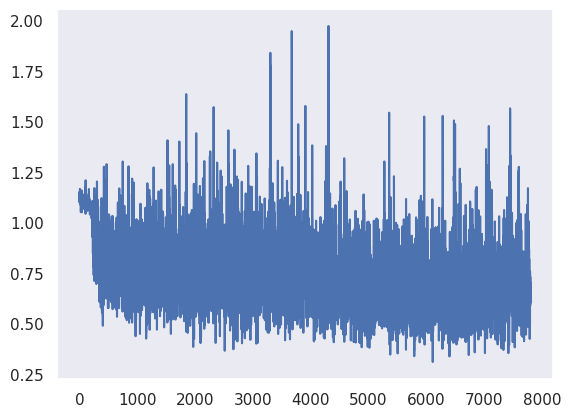

In [44]:
plt.plot(train_losses)

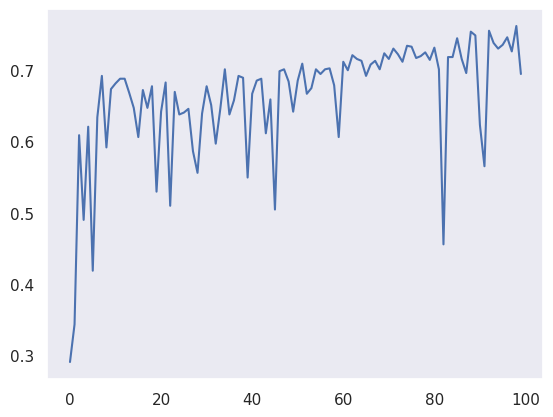

In [45]:
plt.plot(test_accuracy)

In [46]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 527/736 (0.7160)
{'acc_detail': tensor([0.8378, 0.3455, 0.9105], device='cuda:0'),
 'acc_unweighted': tensor(0.6979, device='cuda:0'),
 'acc_weighted': tensor(0.7160, device='cuda:0'),
 'f1s': tensor(0.6859, device='cuda:0'),
 'f1s_detail': tensor([0.8768, 0.4380, 0.7429], device='cuda:0'),
 'precision_detail': tensor([0.9195, 0.5984, 0.6273], device='cuda:0'),
 'recall_detail': tensor([0.8378, 0.3455, 0.9105], device='cuda:0'),
 'rocauc': tensor([0.9735, 0.8312, 0.9196], device='cuda:0'),
 'uar': tensor(0.6979, device='cuda:0'),
 'wap': tensor(0.7215, device='cuda:0')}


tensor([[217,  33,   9],
        [ 14,  76, 130],
        [  5,  18, 234]], device='cuda:0')

In [47]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [48]:
best_epoch = 99
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 578/736 (0.7853)
{'acc_detail': tensor([0.8889, 0.7222, 0.7336], device='cuda:0'),
 'acc_unweighted': tensor(0.7816, device='cuda:0'),
 'acc_weighted': tensor(0.7853, device='cuda:0'),
 'f1s': tensor(0.7806, device='cuda:0'),
 'f1s_detail': tensor([0.8738, 0.6797, 0.7884], device='cuda:0'),
 'precision_detail': tensor([0.8593, 0.6420, 0.8520], device='cuda:0'),
 'recall_detail': tensor([0.8889, 0.7222, 0.7336], device='cuda:0'),
 'rocauc': tensor([0.9752, 0.8625, 0.9229], device='cuda:0'),
 'uar': tensor(0.7816, device='cuda:0'),
 'wap': tensor(0.7929, device='cuda:0')}


tensor([[232,  29,   0],
        [ 27, 156,  33],
        [ 11,  58, 190]], device='cuda:0')

In [49]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [50]:
np.save('../cremad3_m12new_100epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_m12new_100epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [51]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+100, n_epoch4+100 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:19, 19.59s/it]

Train Epoch: 101 [0/2508 (0%)]	Loss: 0.443376
Mem before-during-after: 23301120 111201792 24311808


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:08<15:44, 19.06s/it]

Train Epoch: 101 [1280/2508 (51%)]	Loss: 0.764125
Mem before-during-after: 24311808 112253952 24311808


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:19<15:20, 18.78s/it]


Test Epoch: 101	Accuracy: 559/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_101epoch.pt
Train Epoch: 102 [0/2508 (0%)]	Loss: 0.833322
Mem before-during-after: 24307712 112253952 24311808


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:27<15:22, 19.00s/it]

Train Epoch: 102 [1280/2508 (51%)]	Loss: 0.682465
Mem before-during-after: 24311808 112253952 24311808


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:38<15:02, 18.81s/it]


Test Epoch: 102	Accuracy: 564/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_102epoch.pt
Train Epoch: 103 [0/2508 (0%)]	Loss: 0.610006
Mem before-during-after: 24307712 112253952 24311808


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:45<14:57, 18.87s/it]

Train Epoch: 103 [1280/2508 (51%)]	Loss: 0.624826
Mem before-during-after: 24311808 112253952 24311808


  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [00:57<14:43, 18.81s/it]


Test Epoch: 103	Accuracy: 571/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_103epoch.pt
Train Epoch: 104 [0/2508 (0%)]	Loss: 0.816531
Mem before-during-after: 24307712 112253952 24311808


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:04<14:49, 19.10s/it]

Train Epoch: 104 [1280/2508 (51%)]	Loss: 0.637527
Mem before-during-after: 24311808 112253952 24311808


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:16<14:25, 18.81s/it]


Test Epoch: 104	Accuracy: 580/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_104epoch.pt
Train Epoch: 105 [0/2508 (0%)]	Loss: 0.510634
Mem before-during-after: 24307712 112253952 24311808


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:23<14:34, 19.19s/it]

Train Epoch: 105 [1280/2508 (51%)]	Loss: 0.618109
Mem before-during-after: 24311808 112253952 24311808


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:35<14:00, 18.69s/it]


Test Epoch: 105	Accuracy: 559/736 (74%)

Train Epoch: 106 [0/2508 (0%)]	Loss: 0.417429
Mem before-during-after: 24307712 112253952 24311808


 11%|███████████████████▎                                                                                                                                                              | 5.41584158415842/50 [01:42<13:58, 18.80s/it]

Train Epoch: 106 [1280/2508 (51%)]	Loss: 0.445509
Mem before-during-after: 24311808 112253952 24311808


 12%|█████████████████████▎                                                                                                                                                           | 6.009900990099014/50 [01:53<13:41, 18.67s/it]


Test Epoch: 106	Accuracy: 567/736 (75%)

Train Epoch: 107 [0/2508 (0%)]	Loss: 0.403998
Mem before-during-after: 24307712 112253952 24311808


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:01<14:31, 19.99s/it]

Train Epoch: 107 [1280/2508 (51%)]	Loss: 0.633545
Mem before-during-after: 24311808 112253952 24311808


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:13<14:13, 19.86s/it]


Test Epoch: 107	Accuracy: 568/736 (75%)

Train Epoch: 108 [0/2508 (0%)]	Loss: 0.651252
Mem before-during-after: 24307712 112253952 24311808


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:20<13:22, 18.84s/it]

Train Epoch: 108 [1280/2508 (51%)]	Loss: 0.457032
Mem before-during-after: 24311808 112253952 24311808


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [02:31<13:01, 18.62s/it]


Test Epoch: 108	Accuracy: 579/736 (76%)

Train Epoch: 109 [0/2508 (0%)]	Loss: 0.418294
Mem before-during-after: 24307712 112253952 24311808


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:39<13:01, 18.80s/it]

Train Epoch: 109 [1280/2508 (51%)]	Loss: 0.742227
Mem before-during-after: 24311808 112253952 24311808


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:50<12:42, 18.59s/it]


Test Epoch: 109	Accuracy: 571/736 (75%)

Train Epoch: 110 [0/2508 (0%)]	Loss: 0.566043
Mem before-during-after: 24307712 112253952 24311808


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [02:58<12:53, 19.07s/it]

Train Epoch: 110 [1280/2508 (51%)]	Loss: 0.492904
Mem before-during-after: 24311808 112253952 24311808


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:09<12:19, 18.50s/it]


Test Epoch: 110	Accuracy: 554/736 (73%)

Train Epoch: 111 [0/2508 (0%)]	Loss: 0.855940
Mem before-during-after: 24307712 112253952 24311808


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:17<12:29, 18.93s/it]

Train Epoch: 111 [1280/2508 (51%)]	Loss: 0.535085
Mem before-during-after: 24311808 112253952 24311808


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:28<12:05, 18.60s/it]


Test Epoch: 111	Accuracy: 581/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_111epoch.pt
Train Epoch: 112 [0/2508 (0%)]	Loss: 0.630263
Mem before-during-after: 24307712 112253952 24311808


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.415841584158118/50 [03:36<12:05, 18.79s/it]

Train Epoch: 112 [1280/2508 (51%)]	Loss: 0.506490
Mem before-during-after: 24311808 112253952 24311808


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:47<11:55, 18.83s/it]


Test Epoch: 112	Accuracy: 584/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_112epoch.pt
Train Epoch: 113 [0/2508 (0%)]	Loss: 0.810287
Mem before-during-after: 24307712 112253952 24311808


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [03:54<11:49, 18.87s/it]

Train Epoch: 113 [1280/2508 (51%)]	Loss: 0.835069
Mem before-during-after: 24311808 112253952 24311808


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.00990099009857/50 [04:06<11:36, 18.83s/it]


Test Epoch: 113	Accuracy: 578/736 (76%)

Train Epoch: 114 [0/2508 (0%)]	Loss: 0.581174
Mem before-during-after: 24307712 112253952 24311808


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:13<11:35, 19.02s/it]

Train Epoch: 114 [1280/2508 (51%)]	Loss: 0.455329
Mem before-during-after: 24311808 112253952 24311808


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:25<11:24, 19.02s/it]


Test Epoch: 114	Accuracy: 575/736 (76%)

Train Epoch: 115 [0/2508 (0%)]	Loss: 0.642556
Mem before-during-after: 24307712 112253952 24311808


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:33<11:25, 19.26s/it]

Train Epoch: 115 [1280/2508 (51%)]	Loss: 0.591005
Mem before-during-after: 24311808 112253952 24311808


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:44<10:54, 18.70s/it]


Test Epoch: 115	Accuracy: 584/736 (77%)

Train Epoch: 116 [0/2508 (0%)]	Loss: 0.535062
Mem before-during-after: 24307712 112253952 24311808


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [04:52<11:05, 19.26s/it]

Train Epoch: 116 [1280/2508 (51%)]	Loss: 0.666716
Mem before-during-after: 24311808 112253952 24311808


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [05:03<10:53, 19.22s/it]


Test Epoch: 116	Accuracy: 562/736 (74%)

Train Epoch: 117 [0/2508 (0%)]	Loss: 0.792804
Mem before-during-after: 24307712 112253952 24311808


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:11<10:51, 19.41s/it]

Train Epoch: 117 [1280/2508 (51%)]	Loss: 0.848423
Mem before-during-after: 24311808 112253952 24311808


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:22<10:19, 18.78s/it]


Test Epoch: 117	Accuracy: 585/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_117epoch.pt
Train Epoch: 118 [0/2508 (0%)]	Loss: 0.375847
Mem before-during-after: 24307712 112253952 24311808


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:30<10:17, 18.95s/it]

Train Epoch: 118 [1280/2508 (51%)]	Loss: 0.483957
Mem before-during-after: 24311808 112253952 24311808


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:41<10:03, 18.88s/it]


Test Epoch: 118	Accuracy: 557/736 (73%)

Train Epoch: 119 [0/2508 (0%)]	Loss: 0.548672
Mem before-during-after: 24307712 112253952 24311808


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [05:49<10:04, 19.15s/it]

Train Epoch: 119 [1280/2508 (51%)]	Loss: 0.780865
Mem before-during-after: 24311808 112253952 24311808


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [06:00<09:44, 18.87s/it]


Test Epoch: 119	Accuracy: 564/736 (74%)

Train Epoch: 120 [0/2508 (0%)]	Loss: 0.820638
Mem before-during-after: 24307712 112253952 24311808


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:08<09:46, 19.18s/it]

Train Epoch: 120 [1280/2508 (51%)]	Loss: 0.691490
Mem before-during-after: 24311808 112253952 24311808


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00990099009795/50 [06:19<09:29, 19.00s/it]


Test Epoch: 120	Accuracy: 591/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_120epoch.pt
Train Epoch: 121 [0/2508 (0%)]	Loss: 0.692176
Mem before-during-after: 24307712 112253952 24311808


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:27<09:29, 19.26s/it]

Train Epoch: 121 [1280/2508 (51%)]	Loss: 0.799134
Mem before-during-after: 24311808 112253952 24311808


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:39<09:21, 19.38s/it]


Test Epoch: 121	Accuracy: 595/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_121epoch.pt
Train Epoch: 122 [0/2508 (0%)]	Loss: 0.493729
Mem before-during-after: 24307712 112253952 24311808


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [06:47<09:13, 19.36s/it]

Train Epoch: 122 [1280/2508 (51%)]	Loss: 0.714004
Mem before-during-after: 24311808 112253952 24311808


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [06:58<08:49, 18.93s/it]


Test Epoch: 122	Accuracy: 561/736 (74%)

Train Epoch: 123 [0/2508 (0%)]	Loss: 0.488029
Mem before-during-after: 24307712 112253952 24311808


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [07:06<08:52, 19.32s/it]

Train Epoch: 123 [1280/2508 (51%)]	Loss: 0.666481
Mem before-during-after: 24311808 112253952 24311808


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:17<08:21, 18.57s/it]


Test Epoch: 123	Accuracy: 565/736 (74%)

Train Epoch: 124 [0/2508 (0%)]	Loss: 0.445771
Mem before-during-after: 24307712 112253952 24311808


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:25<08:19, 18.80s/it]

Train Epoch: 124 [1280/2508 (51%)]	Loss: 0.559292
Mem before-during-after: 24311808 112253952 24311808


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:36<08:13, 18.98s/it]


Test Epoch: 124	Accuracy: 588/736 (77%)

Train Epoch: 125 [0/2508 (0%)]	Loss: 0.540088
Mem before-during-after: 24307712 112253952 24311808


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [07:44<08:04, 18.92s/it]

Train Epoch: 125 [1280/2508 (51%)]	Loss: 0.402825
Mem before-during-after: 24311808 112253952 24311808


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [07:55<07:43, 18.56s/it]


Test Epoch: 125	Accuracy: 578/736 (76%)

Train Epoch: 126 [0/2508 (0%)]	Loss: 0.577709
Mem before-during-after: 24307712 112253952 24311808


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [08:03<07:42, 18.82s/it]

Train Epoch: 126 [1280/2508 (51%)]	Loss: 0.445457
Mem before-during-after: 24311808 112253952 24311808


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.009900990097417/50 [08:14<07:26, 18.60s/it]


Test Epoch: 126	Accuracy: 546/736 (72%)

Train Epoch: 127 [0/2508 (0%)]	Loss: 0.584876
Mem before-during-after: 24307712 112253952 24311808


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:21<07:25, 18.90s/it]

Train Epoch: 127 [1280/2508 (51%)]	Loss: 0.777377
Mem before-during-after: 24311808 112253952 24311808


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:33<07:10, 18.71s/it]


Test Epoch: 127	Accuracy: 524/736 (69%)

Train Epoch: 128 [0/2508 (0%)]	Loss: 0.722819
Mem before-during-after: 24307712 112253952 24311808


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [08:40<07:09, 19.02s/it]

Train Epoch: 128 [1280/2508 (51%)]	Loss: 0.499707
Mem before-during-after: 24311808 112253952 24311808


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [08:51<06:48, 18.56s/it]


Test Epoch: 128	Accuracy: 578/736 (76%)

Train Epoch: 129 [0/2508 (0%)]	Loss: 0.455099
Mem before-during-after: 24307712 112253952 24311808


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [08:59<06:46, 18.85s/it]

Train Epoch: 129 [1280/2508 (51%)]	Loss: 0.628037
Mem before-during-after: 24311808 112253952 24311808


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.00990099009715/50 [09:10<06:27, 18.47s/it]


Test Epoch: 129	Accuracy: 589/736 (78%)

Train Epoch: 130 [0/2508 (0%)]	Loss: 0.635295
Mem before-during-after: 24307712 112253952 24311808


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:18<06:28, 18.90s/it]

Train Epoch: 130 [1280/2508 (51%)]	Loss: 0.669534
Mem before-during-after: 24311808 112253952 24311808


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:29<06:11, 18.61s/it]


Test Epoch: 130	Accuracy: 576/736 (76%)

Train Epoch: 131 [0/2508 (0%)]	Loss: 0.651317
Mem before-during-after: 24307712 112253952 24311808


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:37<06:07, 18.77s/it]

Train Epoch: 131 [1280/2508 (51%)]	Loss: 0.766011
Mem before-during-after: 24311808 112253952 24311808


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.009900990096973/50 [09:48<05:52, 18.56s/it]


Test Epoch: 131	Accuracy: 564/736 (74%)

Train Epoch: 132 [0/2508 (0%)]	Loss: 0.555794
Mem before-during-after: 24307712 112253952 24311808


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [09:56<05:50, 18.87s/it]

Train Epoch: 132 [1280/2508 (51%)]	Loss: 0.618597
Mem before-during-after: 24311808 112253952 24311808


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [10:07<05:33, 18.55s/it]


Test Epoch: 132	Accuracy: 589/736 (78%)

Train Epoch: 133 [0/2508 (0%)]	Loss: 0.641639
Mem before-during-after: 24307712 112253952 24311808


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:14<05:31, 18.87s/it]

Train Epoch: 133 [1280/2508 (51%)]	Loss: 0.666150
Mem before-during-after: 24311808 112253952 24311808


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00990099009716/50 [10:26<05:21, 18.90s/it]


Test Epoch: 133	Accuracy: 542/736 (71%)

Train Epoch: 134 [0/2508 (0%)]	Loss: 0.550149
Mem before-during-after: 24307712 112253952 24311808


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:33<05:19, 19.29s/it]

Train Epoch: 134 [1280/2508 (51%)]	Loss: 0.586425
Mem before-during-after: 24311808 112253952 24311808


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [10:45<05:05, 19.09s/it]


Test Epoch: 134	Accuracy: 592/736 (78%)

Train Epoch: 135 [0/2508 (0%)]	Loss: 0.581693
Mem before-during-after: 24307712 112253952 24311808


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [10:52<04:52, 18.79s/it]

Train Epoch: 135 [1280/2508 (51%)]	Loss: 0.766222
Mem before-during-after: 24311808 112253952 24311808


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [11:04<04:39, 18.62s/it]


Test Epoch: 135	Accuracy: 575/736 (76%)

Train Epoch: 136 [0/2508 (0%)]	Loss: 0.689408
Mem before-during-after: 24307712 112253952 24311808


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [11:11<04:35, 18.90s/it]

Train Epoch: 136 [1280/2508 (51%)]	Loss: 0.739461
Mem before-during-after: 24311808 112253952 24311808


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00990099009797/50 [11:22<04:18, 18.50s/it]


Test Epoch: 136	Accuracy: 593/736 (78%)

Train Epoch: 137 [0/2508 (0%)]	Loss: 0.351289
Mem before-during-after: 24307712 112253952 24311808


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:30<04:15, 18.82s/it]

Train Epoch: 137 [1280/2508 (51%)]	Loss: 0.956881
Mem before-during-after: 24311808 112253952 24311808


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999999226/50 [11:41<04:02, 18.62s/it]


Test Epoch: 137	Accuracy: 559/736 (74%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.01980198019725/50 [11:41<04:10, 19.32s/it]

Train Epoch: 138 [0/2508 (0%)]	Loss: 0.582721
Mem before-during-after: 24307712 112253952 24311808


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [11:49<03:56, 18.78s/it]

Train Epoch: 138 [1280/2508 (51%)]	Loss: 0.664251
Mem before-during-after: 24311808 112253952 24311808


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [12:00<03:45, 18.77s/it]


Test Epoch: 138	Accuracy: 575/736 (76%)

Train Epoch: 139 [0/2508 (0%)]	Loss: 0.632224
Mem before-during-after: 24307712 112253952 24311808


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [12:08<03:39, 18.93s/it]

Train Epoch: 139 [1280/2508 (51%)]	Loss: 0.401719
Mem before-during-after: 24311808 112253952 24311808


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [12:19<03:27, 18.88s/it]


Test Epoch: 139	Accuracy: 584/736 (77%)

Train Epoch: 140 [0/2508 (0%)]	Loss: 0.460509
Mem before-during-after: 24307712 112253952 24311808


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:27<03:24, 19.35s/it]

Train Epoch: 140 [1280/2508 (51%)]	Loss: 0.524006
Mem before-during-after: 24311808 112253952 24311808


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [12:38<03:09, 18.96s/it]


Test Epoch: 140	Accuracy: 594/736 (78%)

Train Epoch: 141 [0/2508 (0%)]	Loss: 0.425816
Mem before-during-after: 24307712 112253952 24311808


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [12:46<03:04, 19.30s/it]

Train Epoch: 141 [1280/2508 (51%)]	Loss: 0.488288
Mem before-during-after: 24311808 112253952 24311808


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [12:58<02:50, 19.00s/it]


Test Epoch: 141	Accuracy: 449/736 (59%)

Train Epoch: 142 [0/2508 (0%)]	Loss: 1.023144
Mem before-during-after: 24307712 112253952 24311808


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [13:05<02:45, 19.33s/it]

Train Epoch: 142 [1280/2508 (51%)]	Loss: 0.581728
Mem before-during-after: 24311808 112253952 24311808


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00990099009959/50 [13:17<02:27, 18.52s/it]


Test Epoch: 142	Accuracy: 558/736 (74%)

Train Epoch: 143 [0/2508 (0%)]	Loss: 0.605373
Mem before-during-after: 24307712 112253952 24311808


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:24<02:22, 18.81s/it]

Train Epoch: 143 [1280/2508 (51%)]	Loss: 0.537351
Mem before-during-after: 24311808 112253952 24311808


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [13:35<02:09, 18.47s/it]


Test Epoch: 143	Accuracy: 579/736 (76%)

Train Epoch: 144 [0/2508 (0%)]	Loss: 0.547147
Mem before-during-after: 24307712 112253952 24311808


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [13:43<02:03, 18.77s/it]

Train Epoch: 144 [1280/2508 (51%)]	Loss: 0.386642
Mem before-during-after: 24311808 112253952 24311808


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [13:54<01:51, 18.70s/it]


Test Epoch: 144	Accuracy: 550/736 (72%)

Train Epoch: 145 [0/2508 (0%)]	Loss: 0.558385
Mem before-during-after: 24307712 112253952 24311808


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.415841584159644/50 [14:02<01:44, 18.78s/it]

Train Epoch: 145 [1280/2508 (51%)]	Loss: 0.611928
Mem before-during-after: 24311808 112253952 24311808


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 45.0099009901004/50 [14:13<01:34, 18.89s/it]


Test Epoch: 145	Accuracy: 541/736 (71%)

Train Epoch: 146 [0/2508 (0%)]	Loss: 0.997126
Mem before-during-after: 24307712 112253952 24311808


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:21<01:26, 18.87s/it]

Train Epoch: 146 [1280/2508 (51%)]	Loss: 0.316960
Mem before-during-after: 24311808 112253952 24311808


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [14:32<01:14, 18.57s/it]


Test Epoch: 146	Accuracy: 590/736 (78%)

Train Epoch: 147 [0/2508 (0%)]	Loss: 0.385800
Mem before-during-after: 24307712 112253952 24311808


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [14:40<01:07, 18.81s/it]

Train Epoch: 147 [1280/2508 (51%)]	Loss: 0.467509
Mem before-during-after: 24311808 112253952 24311808


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [14:51<00:55, 18.54s/it]


Test Epoch: 147	Accuracy: 533/736 (70%)

Train Epoch: 148 [0/2508 (0%)]	Loss: 0.840884
Mem before-during-after: 24307712 112253952 24311808


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [14:58<00:48, 18.80s/it]

Train Epoch: 148 [1280/2508 (51%)]	Loss: 0.479978
Mem before-during-after: 24311808 112253952 24311808


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [15:10<00:37, 18.62s/it]


Test Epoch: 148	Accuracy: 573/736 (75%)

Train Epoch: 149 [0/2508 (0%)]	Loss: 0.723167
Mem before-during-after: 24307712 112253952 24311808


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [15:17<00:29, 18.81s/it]

Train Epoch: 149 [1280/2508 (51%)]	Loss: 0.518579
Mem before-during-after: 24311808 112253952 24311808


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [15:29<00:18, 18.91s/it]


Test Epoch: 149	Accuracy: 594/736 (78%)

Train Epoch: 150 [0/2508 (0%)]	Loss: 0.550022
Mem before-during-after: 24307712 112253952 24311808


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.415841584160994/50 [15:36<00:11, 19.21s/it]

Train Epoch: 150 [1280/2508 (51%)]	Loss: 0.464932
Mem before-during-after: 24311808 112253952 24311808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [15:48<00:00, 18.96s/it]


Test Epoch: 150	Accuracy: 573/736 (75%)



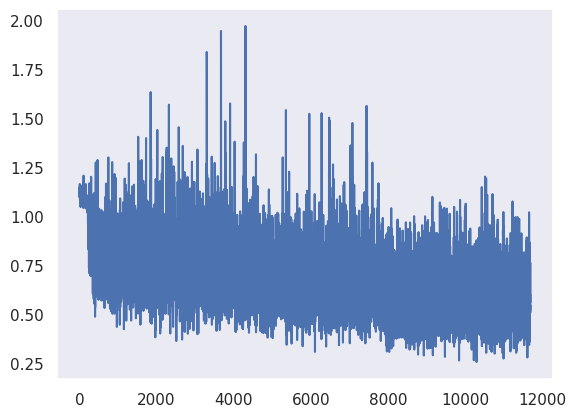

In [52]:
plt.plot(train_losses)

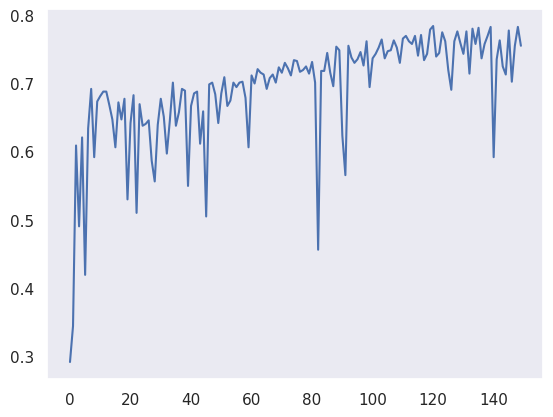

In [53]:
plt.plot(test_accuracy)

In [54]:
metrics4, confusion_matrix4 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics4.compute())
confusion_matrix4.compute()

Correct: 573/736 (0.7785)
{'acc_detail': tensor([0.8161, 0.7285, 0.7835], device='cuda:0'),
 'acc_unweighted': tensor(0.7760, device='cuda:0'),
 'acc_weighted': tensor(0.7785, device='cuda:0'),
 'f1s': tensor(0.7787, device='cuda:0'),
 'f1s_detail': tensor([0.8875, 0.6667, 0.7819], device='cuda:0'),
 'precision_detail': tensor([0.9726, 0.6145, 0.7804], device='cuda:0'),
 'recall_detail': tensor([0.8161, 0.7285, 0.7835], device='cuda:0'),
 'rocauc': tensor([0.9824, 0.8696, 0.9279], device='cuda:0'),
 'uar': tensor(0.7760, device='cuda:0'),
 'wap': tensor(0.7987, device='cuda:0')}


tensor([[213,  48,   0],
        [  4, 161,  56],
        [  2,  53, 199]], device='cuda:0')

In [55]:
np.save('../cremad3_m12new_150epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_m12new_150epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [56]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [57]:
best_epoch = 121
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 596/736 (0.8098)
{'acc_detail': tensor([0.9186, 0.7376, 0.7626], device='cuda:0'),
 'acc_unweighted': tensor(0.8063, device='cuda:0'),
 'acc_weighted': tensor(0.8098, device='cuda:0'),
 'f1s': tensor(0.8055, device='cuda:0'),
 'f1s_detail': tensor([0.9063, 0.7102, 0.8000], device='cuda:0'),
 'precision_detail': tensor([0.8943, 0.6849, 0.8412], device='cuda:0'),
 'recall_detail': tensor([0.9186, 0.7376, 0.7626], device='cuda:0'),
 'rocauc': tensor([0.9794, 0.8740, 0.9258], device='cuda:0'),
 'uar': tensor(0.8063, device='cuda:0'),
 'wap': tensor(0.8129, device='cuda:0')}


tensor([[237,  21,   0],
        [ 21, 163,  37],
        [  7,  54, 196]], device='cuda:0')

In [58]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
n_epoch5 = 200
# train_losses = []
# test_accuracy = []
# best_accuracy = max(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch5)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch5) as pbar:
    for epoch in range(1+150, n_epoch5+150 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.019801980198019802/200 [00:00<1:06:20, 19.90s/it]

Train Epoch: 151 [0/2508 (0%)]	Loss: 0.636784
Mem before-during-after: 25006592 112907264 26017280


  0%|▎                                                                                                                                                                           | 0.41584158415841604/200 [00:08<1:03:51, 19.20s/it]

Train Epoch: 151 [1280/2508 (51%)]	Loss: 0.807599
Mem before-during-after: 26017280 113959424 26017280


  1%|▊                                                                                                                                                                            | 1.0099009900990106/200 [00:19<1:03:24, 19.12s/it]


Test Epoch: 151	Accuracy: 591/736 (78%)

Train Epoch: 152 [0/2508 (0%)]	Loss: 0.489771
Mem before-during-after: 26013184 113959424 26017280


  1%|█▏                                                                                                                                                                           | 1.4158415841584169/200 [00:27<1:04:05, 19.36s/it]

Train Epoch: 152 [1280/2508 (51%)]	Loss: 0.537895
Mem before-during-after: 26017280 113959424 26017280


  1%|█▋                                                                                                                                                                           | 2.0099009900990112/200 [00:38<1:02:34, 18.97s/it]


Test Epoch: 152	Accuracy: 591/736 (78%)

Train Epoch: 153 [0/2508 (0%)]	Loss: 0.609196
Mem before-during-after: 26013184 113959424 26017280


  1%|██                                                                                                                                                                           | 2.4158415841584175/200 [00:46<1:03:39, 19.33s/it]

Train Epoch: 153 [1280/2508 (51%)]	Loss: 0.577257
Mem before-during-after: 26017280 113959424 26017280


  2%|██▌                                                                                                                                                                           | 3.009900990099012/200 [00:58<1:02:50, 19.14s/it]


Test Epoch: 153	Accuracy: 594/736 (78%)

Train Epoch: 154 [0/2508 (0%)]	Loss: 0.837878
Mem before-during-after: 26013184 113959424 26017280


  2%|██▉                                                                                                                                                                          | 3.4158415841584184/200 [01:06<1:04:34, 19.71s/it]

Train Epoch: 154 [1280/2508 (51%)]	Loss: 0.524418
Mem before-during-after: 26017280 113959424 26017280


  2%|███▍                                                                                                                                                                          | 4.009900990099013/200 [01:17<1:02:23, 19.10s/it]


Test Epoch: 154	Accuracy: 548/736 (72%)

Train Epoch: 155 [0/2508 (0%)]	Loss: 0.540950
Mem before-during-after: 26013184 113959424 26017280


  2%|███▊                                                                                                                                                                          | 4.415841584158419/200 [01:25<1:03:12, 19.39s/it]

Train Epoch: 155 [1280/2508 (51%)]	Loss: 0.752632
Mem before-during-after: 26017280 113959424 26017280


  3%|████▎                                                                                                                                                                        | 5.0099009900990135/200 [01:37<1:02:04, 19.10s/it]


Test Epoch: 155	Accuracy: 581/736 (77%)

Train Epoch: 156 [0/2508 (0%)]	Loss: 0.662718
Mem before-during-after: 26013184 113959424 26017280


  3%|████▋                                                                                                                                                                          | 5.41584158415842/200 [01:45<1:03:12, 19.49s/it]

Train Epoch: 156 [1280/2508 (51%)]	Loss: 0.592645
Mem before-during-after: 26017280 113959424 26017280


  3%|█████▏                                                                                                                                                                        | 6.009900990099014/200 [01:56<1:01:42, 19.09s/it]


Test Epoch: 156	Accuracy: 591/736 (78%)

Train Epoch: 157 [0/2508 (0%)]	Loss: 0.662396
Mem before-during-after: 26013184 113959424 26017280


  3%|█████▍                                                                                                                                                                       | 6.3267326732673315/200 [02:02<1:02:29, 19.36s/it]